# ALS Detection with Action Recognition

### Import Libraries and Dependencies

In [1]:
import tensorflow
import cv2
import mediapipe as mp
from matplotlib import pyplot as plt
import sklearn
import os
import numpy as np

### Detect Face, Hand, and Pose Landmarks

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    # BGR -> RGB -> BGR
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Color Conversion
    image.flags.writeable = False # Image is no longer writeable
    results = model.process(image) # Make prediction
    image.flags.writeable = True # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Color Conversion
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                              mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80, 256, 121),thickness=1, circle_radius=1)
                              ) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                              mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80, 44, 121),thickness=2, circle_radius=2)
                              ) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                              mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121, 44, 250),thickness=2, circle_radius=2)
                              ) # Draw lh connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                              mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245, 66, 230),thickness=2, circle_radius=2)
                              ) # Draw rh connections

In [5]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        image, results = mediapipe_detection(frame, holistic)
        draw_styled_landmarks(image, results)
        cv2.imshow("OpenCV Camera", image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

KeyboardInterrupt: 

In [6]:
draw_styled_landmarks(frame, results)

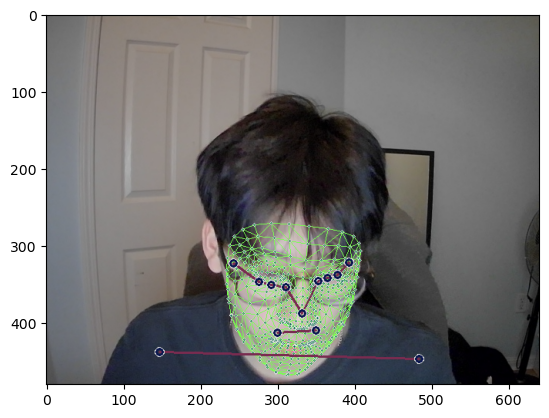

In [8]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

### Extract Keypoint Values

In [7]:
results.pose_landmarks

landmark {
  x: 0.4262988567352295
  y: 0.6234251260757446
  z: -0.7554980516433716
  visibility: 0.9995154142379761
}
landmark {
  x: 0.46938514709472656
  y: 0.5498318076133728
  z: -0.7710432410240173
  visibility: 0.9985491037368774
}
landmark {
  x: 0.49243712425231934
  y: 0.554867148399353
  z: -0.7707918882369995
  visibility: 0.9988154768943787
}
landmark {
  x: 0.5197822451591492
  y: 0.561381995677948
  z: -0.7711038589477539
  visibility: 0.9985581040382385
}
landmark {
  x: 0.4313255250453949
  y: 0.5344730019569397
  z: -0.7323590517044067
  visibility: 0.9988548159599304
}
landmark {
  x: 0.4224814474582672
  y: 0.5273972749710083
  z: -0.7312056422233582
  visibility: 0.9990542531013489
}
landmark {
  x: 0.41271811723709106
  y: 0.5204665064811707
  z: -0.7316210269927979
  visibility: 0.9989678859710693
}
landmark {
  x: 0.5844454169273376
  y: 0.5884007215499878
  z: -0.5745746493339539
  visibility: 0.9987803101539612
}
landmark {
  x: 0.4301295280456543
  y: 0.53623

In [10]:
def extract_keypoints(results):
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3) 
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, left_hand, right_hand])

In [11]:
result_test = extract_keypoints(results)

### Folder Setup

In [18]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

### Collecting Keypoint Values for Training and Testing

In [64]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

KeyboardInterrupt: 

In [17]:
cap.release()
cv2.destroyAllWindows()

### Preprocess Data and Create Labels and Features

In [20]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [21]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [22]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [23]:
X = np.array(sequences)

In [25]:
y = to_categorical(labels).astype(int)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

### Build and Train LSTM Neural Network

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [29]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [47]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [48]:
res = [.7, 0.2, 0.1]
actions[np.argmax(res)]
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [32]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])
model.summary()

Epoch 1/2000
3/3 [==============================] - 6s 129ms/step - loss: 8.0014 - categorical_accuracy: 0.3529
Epoch 2/2000
3/3 [==============================] - 0s 99ms/step - loss: 16.3960 - categorical_accuracy: 0.3294
Epoch 3/2000
3/3 [==============================] - 1s 197ms/step - loss: 16.2008 - categorical_accuracy: 0.3529
Epoch 4/2000
3/3 [==============================] - 0s 108ms/step - loss: 9.6901 - categorical_accuracy: 0.3412
Epoch 5/2000
3/3 [==============================] - 0s 104ms/step - loss: 21.6890 - categorical_accuracy: 0.3176
Epoch 6/2000
3/3 [==============================] - 0s 173ms/step - loss: 17.8477 - categorical_accuracy: 0.2824
Epoch 7/2000
3/3 [==============================] - 0s 90ms/step - loss: 13.7985 - categorical_accuracy: 0.2706
Epoch 8/2000
3/3 [==============================] - 0s 111ms/step - loss: 14.5959 - categorical_accuracy: 0.3294
Epoch 9/2000
3/3 [==============================] - 0s 86ms/step - loss: 12.3331 - categorical_accur

3/3 [==============================] - 0s 137ms/step - loss: 12.8160 - categorical_accuracy: 0.2588
Epoch 74/2000
3/3 [==============================] - 0s 117ms/step - loss: 18.8339 - categorical_accuracy: 0.3294
Epoch 75/2000
3/3 [==============================] - 0s 139ms/step - loss: 8.5085 - categorical_accuracy: 0.3412
Epoch 76/2000
3/3 [==============================] - 1s 203ms/step - loss: 16.1175 - categorical_accuracy: 0.3765
Epoch 77/2000
3/3 [==============================] - 1s 182ms/step - loss: 12.3649 - categorical_accuracy: 0.2588
Epoch 78/2000
3/3 [==============================] - 0s 104ms/step - loss: 8.1822 - categorical_accuracy: 0.2353
Epoch 79/2000
3/3 [==============================] - 0s 84ms/step - loss: 10.4429 - categorical_accuracy: 0.3176
Epoch 80/2000
3/3 [==============================] - 0s 86ms/step - loss: 11.0913 - categorical_accuracy: 0.3294
Epoch 81/2000
3/3 [==============================] - 0s 86ms/step - loss: 8.3349 - categorical_accuracy: 0

3/3 [==============================] - 0s 151ms/step - loss: 12.7220 - categorical_accuracy: 0.3294
Epoch 146/2000
3/3 [==============================] - 1s 218ms/step - loss: 12.4073 - categorical_accuracy: 0.2706
Epoch 147/2000
3/3 [==============================] - 0s 134ms/step - loss: 14.0143 - categorical_accuracy: 0.2824
Epoch 148/2000
3/3 [==============================] - 0s 126ms/step - loss: 9.2485 - categorical_accuracy: 0.3059
Epoch 149/2000
3/3 [==============================] - 0s 137ms/step - loss: 4.7076 - categorical_accuracy: 0.2706
Epoch 150/2000
3/3 [==============================] - 0s 122ms/step - loss: 9.6949 - categorical_accuracy: 0.2471
Epoch 151/2000
3/3 [==============================] - 0s 122ms/step - loss: 4.7214 - categorical_accuracy: 0.3529
Epoch 152/2000
3/3 [==============================] - 0s 130ms/step - loss: 3.9121 - categorical_accuracy: 0.4000
Epoch 153/2000
3/3 [==============================] - 0s 120ms/step - loss: 4.9975 - categorical_acc

3/3 [==============================] - 0s 97ms/step - loss: 3.8377 - categorical_accuracy: 0.3294
Epoch 218/2000
3/3 [==============================] - 0s 105ms/step - loss: 2.2041 - categorical_accuracy: 0.3294
Epoch 219/2000
3/3 [==============================] - 0s 96ms/step - loss: 2.6635 - categorical_accuracy: 0.2706
Epoch 220/2000
3/3 [==============================] - 0s 100ms/step - loss: 2.8490 - categorical_accuracy: 0.3647
Epoch 221/2000
3/3 [==============================] - 0s 107ms/step - loss: 3.3845 - categorical_accuracy: 0.3647
Epoch 222/2000
3/3 [==============================] - 0s 105ms/step - loss: 3.6948 - categorical_accuracy: 0.3529
Epoch 223/2000
3/3 [==============================] - 0s 127ms/step - loss: 3.5373 - categorical_accuracy: 0.3529
Epoch 224/2000
3/3 [==============================] - 0s 112ms/step - loss: 2.9695 - categorical_accuracy: 0.3765
Epoch 225/2000
3/3 [==============================] - 0s 99ms/step - loss: 2.5702 - categorical_accuracy:

3/3 [==============================] - 0s 166ms/step - loss: 1.7385 - categorical_accuracy: 0.3294
Epoch 290/2000
3/3 [==============================] - 0s 113ms/step - loss: 2.1210 - categorical_accuracy: 0.2824
Epoch 291/2000
3/3 [==============================] - 1s 182ms/step - loss: 1.7150 - categorical_accuracy: 0.3059
Epoch 292/2000
3/3 [==============================] - 0s 101ms/step - loss: 1.4826 - categorical_accuracy: 0.2941
Epoch 293/2000
3/3 [==============================] - 0s 100ms/step - loss: 1.7400 - categorical_accuracy: 0.3059
Epoch 294/2000
3/3 [==============================] - 0s 154ms/step - loss: 1.5369 - categorical_accuracy: 0.4235
Epoch 295/2000
3/3 [==============================] - 0s 153ms/step - loss: 1.8452 - categorical_accuracy: 0.3765
Epoch 296/2000
3/3 [==============================] - 0s 145ms/step - loss: 1.8568 - categorical_accuracy: 0.2588
Epoch 297/2000
3/3 [==============================] - 0s 112ms/step - loss: 1.6652 - categorical_accura

3/3 [==============================] - 0s 119ms/step - loss: 1.4687 - categorical_accuracy: 0.3294
Epoch 362/2000
3/3 [==============================] - 0s 103ms/step - loss: 1.3772 - categorical_accuracy: 0.3176
Epoch 363/2000
3/3 [==============================] - 0s 102ms/step - loss: 1.5433 - categorical_accuracy: 0.3412
Epoch 364/2000
3/3 [==============================] - 0s 137ms/step - loss: 1.3436 - categorical_accuracy: 0.3294
Epoch 365/2000
3/3 [==============================] - 0s 97ms/step - loss: 1.5183 - categorical_accuracy: 0.3176
Epoch 366/2000
3/3 [==============================] - 0s 114ms/step - loss: 1.5925 - categorical_accuracy: 0.3059
Epoch 367/2000
3/3 [==============================] - 0s 112ms/step - loss: 1.5631 - categorical_accuracy: 0.3765
Epoch 368/2000
3/3 [==============================] - 0s 103ms/step - loss: 1.4583 - categorical_accuracy: 0.4118
Epoch 369/2000
3/3 [==============================] - 0s 103ms/step - loss: 1.4058 - categorical_accurac

3/3 [==============================] - 0s 102ms/step - loss: 1.3611 - categorical_accuracy: 0.3294
Epoch 434/2000
3/3 [==============================] - 0s 103ms/step - loss: 1.2275 - categorical_accuracy: 0.3529
Epoch 435/2000
3/3 [==============================] - 0s 102ms/step - loss: 1.4544 - categorical_accuracy: 0.3176
Epoch 436/2000
3/3 [==============================] - 0s 101ms/step - loss: 1.6566 - categorical_accuracy: 0.3294
Epoch 437/2000
3/3 [==============================] - 0s 101ms/step - loss: 1.3563 - categorical_accuracy: 0.4353
Epoch 438/2000
3/3 [==============================] - 0s 104ms/step - loss: 1.1508 - categorical_accuracy: 0.3882
Epoch 439/2000
3/3 [==============================] - 0s 98ms/step - loss: 1.3864 - categorical_accuracy: 0.2941
Epoch 440/2000
3/3 [==============================] - 0s 99ms/step - loss: 1.2462 - categorical_accuracy: 0.2588
Epoch 441/2000
3/3 [==============================] - 0s 103ms/step - loss: 1.1346 - categorical_accuracy

3/3 [==============================] - 0s 111ms/step - loss: 1.2047 - categorical_accuracy: 0.2941
Epoch 506/2000
3/3 [==============================] - 0s 109ms/step - loss: 1.1584 - categorical_accuracy: 0.2941
Epoch 507/2000
3/3 [==============================] - 0s 118ms/step - loss: 1.1219 - categorical_accuracy: 0.3529
Epoch 508/2000
3/3 [==============================] - 0s 104ms/step - loss: 1.4537 - categorical_accuracy: 0.1882
Epoch 509/2000
3/3 [==============================] - 0s 112ms/step - loss: 1.1330 - categorical_accuracy: 0.3765
Epoch 510/2000
3/3 [==============================] - 0s 111ms/step - loss: 1.0401 - categorical_accuracy: 0.5059
Epoch 511/2000
3/3 [==============================] - 0s 105ms/step - loss: 1.1707 - categorical_accuracy: 0.3765
Epoch 512/2000
3/3 [==============================] - 0s 119ms/step - loss: 1.0780 - categorical_accuracy: 0.3529
Epoch 513/2000
3/3 [==============================] - 0s 118ms/step - loss: 1.0744 - categorical_accura

3/3 [==============================] - 0s 103ms/step - loss: 1.1079 - categorical_accuracy: 0.3882
Epoch 578/2000
3/3 [==============================] - 0s 99ms/step - loss: 1.2114 - categorical_accuracy: 0.3882
Epoch 579/2000
3/3 [==============================] - 0s 98ms/step - loss: 1.2471 - categorical_accuracy: 0.3294
Epoch 580/2000
3/3 [==============================] - 0s 102ms/step - loss: 1.1931 - categorical_accuracy: 0.4824
Epoch 581/2000
3/3 [==============================] - 0s 107ms/step - loss: 1.1928 - categorical_accuracy: 0.3647
Epoch 582/2000
3/3 [==============================] - 0s 107ms/step - loss: 1.0249 - categorical_accuracy: 0.4941
Epoch 583/2000
3/3 [==============================] - 0s 108ms/step - loss: 1.2699 - categorical_accuracy: 0.2588
Epoch 584/2000
3/3 [==============================] - 0s 108ms/step - loss: 1.1940 - categorical_accuracy: 0.4235
Epoch 585/2000
3/3 [==============================] - 0s 100ms/step - loss: 1.1965 - categorical_accuracy

3/3 [==============================] - 0s 103ms/step - loss: 1.1548 - categorical_accuracy: 0.4353
Epoch 650/2000
3/3 [==============================] - 0s 98ms/step - loss: 1.0137 - categorical_accuracy: 0.4471
Epoch 651/2000
3/3 [==============================] - 0s 109ms/step - loss: 0.9500 - categorical_accuracy: 0.5294
Epoch 652/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.9873 - categorical_accuracy: 0.5059
Epoch 653/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.9715 - categorical_accuracy: 0.5529
Epoch 654/2000
3/3 [==============================] - 0s 124ms/step - loss: 1.2476 - categorical_accuracy: 0.3765
Epoch 655/2000
3/3 [==============================] - 0s 107ms/step - loss: 1.2920 - categorical_accuracy: 0.3647
Epoch 656/2000
3/3 [==============================] - 0s 101ms/step - loss: 2.2233 - categorical_accuracy: 0.3294
Epoch 657/2000
3/3 [==============================] - 0s 98ms/step - loss: 1.8915 - categorical_accuracy

3/3 [==============================] - 0s 99ms/step - loss: 1.0994 - categorical_accuracy: 0.4118
Epoch 722/2000
3/3 [==============================] - 0s 102ms/step - loss: 1.0783 - categorical_accuracy: 0.4824
Epoch 723/2000
3/3 [==============================] - 0s 108ms/step - loss: 1.0396 - categorical_accuracy: 0.4471
Epoch 724/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.9707 - categorical_accuracy: 0.5294
Epoch 725/2000
3/3 [==============================] - 0s 103ms/step - loss: 1.0010 - categorical_accuracy: 0.4471
Epoch 726/2000
3/3 [==============================] - 0s 96ms/step - loss: 1.0358 - categorical_accuracy: 0.4118
Epoch 727/2000
3/3 [==============================] - 0s 107ms/step - loss: 0.9696 - categorical_accuracy: 0.5294
Epoch 728/2000
3/3 [==============================] - 0s 109ms/step - loss: 0.9574 - categorical_accuracy: 0.5765
Epoch 729/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.9569 - categorical_accuracy

3/3 [==============================] - 0s 98ms/step - loss: 1.8188 - categorical_accuracy: 0.3412
Epoch 794/2000
3/3 [==============================] - 0s 102ms/step - loss: 1.4729 - categorical_accuracy: 0.3882
Epoch 795/2000
3/3 [==============================] - 0s 101ms/step - loss: 1.3849 - categorical_accuracy: 0.3765
Epoch 796/2000
3/3 [==============================] - 0s 111ms/step - loss: 1.6058 - categorical_accuracy: 0.3529
Epoch 797/2000
3/3 [==============================] - 0s 104ms/step - loss: 1.4064 - categorical_accuracy: 0.3529
Epoch 798/2000
3/3 [==============================] - 0s 109ms/step - loss: 1.5318 - categorical_accuracy: 0.3765
Epoch 799/2000
3/3 [==============================] - 0s 104ms/step - loss: 1.7535 - categorical_accuracy: 0.3529
Epoch 800/2000
3/3 [==============================] - 0s 97ms/step - loss: 1.5393 - categorical_accuracy: 0.3059
Epoch 801/2000
3/3 [==============================] - 0s 105ms/step - loss: 1.2078 - categorical_accuracy

3/3 [==============================] - 0s 109ms/step - loss: 1.5195 - categorical_accuracy: 0.3765
Epoch 866/2000
3/3 [==============================] - 0s 104ms/step - loss: 1.1828 - categorical_accuracy: 0.4353
Epoch 867/2000
3/3 [==============================] - 0s 103ms/step - loss: 1.0573 - categorical_accuracy: 0.4706
Epoch 868/2000
3/3 [==============================] - 0s 104ms/step - loss: 1.1338 - categorical_accuracy: 0.4118
Epoch 869/2000
3/3 [==============================] - 0s 114ms/step - loss: 1.0592 - categorical_accuracy: 0.4471
Epoch 870/2000
3/3 [==============================] - 0s 110ms/step - loss: 1.1038 - categorical_accuracy: 0.4118
Epoch 871/2000
3/3 [==============================] - 0s 139ms/step - loss: 1.1227 - categorical_accuracy: 0.4118
Epoch 872/2000
3/3 [==============================] - 0s 110ms/step - loss: 1.1422 - categorical_accuracy: 0.4941
Epoch 873/2000
3/3 [==============================] - 0s 116ms/step - loss: 1.2568 - categorical_accura

3/3 [==============================] - 0s 102ms/step - loss: 0.9947 - categorical_accuracy: 0.5882
Epoch 938/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.9604 - categorical_accuracy: 0.5059
Epoch 939/2000
3/3 [==============================] - 0s 101ms/step - loss: 1.0845 - categorical_accuracy: 0.3647
Epoch 940/2000
3/3 [==============================] - 0s 102ms/step - loss: 1.0949 - categorical_accuracy: 0.4471
Epoch 941/2000
3/3 [==============================] - 0s 108ms/step - loss: 1.0199 - categorical_accuracy: 0.4941
Epoch 942/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.9885 - categorical_accuracy: 0.5176
Epoch 943/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.9067 - categorical_accuracy: 0.5647
Epoch 944/2000
3/3 [==============================] - 0s 104ms/step - loss: 1.1173 - categorical_accuracy: 0.4118
Epoch 945/2000
3/3 [==============================] - 0s 99ms/step - loss: 1.0750 - categorical_accuracy:

3/3 [==============================] - 0s 145ms/step - loss: 0.8385 - categorical_accuracy: 0.5647
Epoch 1010/2000
3/3 [==============================] - 0s 130ms/step - loss: 0.8503 - categorical_accuracy: 0.5765
Epoch 1011/2000
3/3 [==============================] - 0s 129ms/step - loss: 0.9284 - categorical_accuracy: 0.4706
Epoch 1012/2000
3/3 [==============================] - 0s 146ms/step - loss: 1.0648 - categorical_accuracy: 0.4941
Epoch 1013/2000
3/3 [==============================] - 0s 145ms/step - loss: 0.9154 - categorical_accuracy: 0.5765
Epoch 1014/2000
3/3 [==============================] - 0s 130ms/step - loss: 0.8708 - categorical_accuracy: 0.4471
Epoch 1015/2000
3/3 [==============================] - 0s 131ms/step - loss: 0.8648 - categorical_accuracy: 0.5647
Epoch 1016/2000
3/3 [==============================] - 0s 149ms/step - loss: 0.8818 - categorical_accuracy: 0.5882
Epoch 1017/2000
3/3 [==============================] - 0s 138ms/step - loss: 0.9091 - categorica

3/3 [==============================] - 0s 113ms/step - loss: 0.7944 - categorical_accuracy: 0.6471
Epoch 1081/2000
3/3 [==============================] - 0s 115ms/step - loss: 1.4455 - categorical_accuracy: 0.3882
Epoch 1082/2000
3/3 [==============================] - 0s 110ms/step - loss: 1.0177 - categorical_accuracy: 0.5412
Epoch 1083/2000
3/3 [==============================] - 0s 102ms/step - loss: 1.2065 - categorical_accuracy: 0.6471
Epoch 1084/2000
3/3 [==============================] - 0s 101ms/step - loss: 1.0509 - categorical_accuracy: 0.4706
Epoch 1085/2000
3/3 [==============================] - 0s 102ms/step - loss: 1.1862 - categorical_accuracy: 0.3529
Epoch 1086/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.9366 - categorical_accuracy: 0.5765
Epoch 1087/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.7810 - categorical_accuracy: 0.6118
Epoch 1088/2000
3/3 [==============================] - 0s 115ms/step - loss: 0.7111 - categorica

3/3 [==============================] - 0s 102ms/step - loss: 0.6455 - categorical_accuracy: 0.6824
Epoch 1152/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.6920 - categorical_accuracy: 0.6706
Epoch 1153/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.6446 - categorical_accuracy: 0.7176
Epoch 1154/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.6349 - categorical_accuracy: 0.6471
Epoch 1155/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.5676 - categorical_accuracy: 0.7647
Epoch 1156/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.5724 - categorical_accuracy: 0.7765
Epoch 1157/2000
3/3 [==============================] - 0s 109ms/step - loss: 0.5814 - categorical_accuracy: 0.7412
Epoch 1158/2000
3/3 [==============================] - 0s 102ms/step - loss: 0.7417 - categorical_accuracy: 0.6706
Epoch 1159/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.8591 - categorica

3/3 [==============================] - 0s 102ms/step - loss: 0.6695 - categorical_accuracy: 0.6824
Epoch 1223/2000
3/3 [==============================] - 0s 111ms/step - loss: 0.5895 - categorical_accuracy: 0.7294
Epoch 1224/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.6842 - categorical_accuracy: 0.7059
Epoch 1225/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.6019 - categorical_accuracy: 0.7176
Epoch 1226/2000
3/3 [==============================] - 0s 146ms/step - loss: 0.7576 - categorical_accuracy: 0.6235
Epoch 1227/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.6180 - categorical_accuracy: 0.7529
Epoch 1228/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.5829 - categorical_accuracy: 0.7412
Epoch 1229/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.8268 - categorical_accuracy: 0.6471
Epoch 1230/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.8119 - categorica

3/3 [==============================] - 0s 104ms/step - loss: 0.6426 - categorical_accuracy: 0.7059
Epoch 1294/2000
3/3 [==============================] - 0s 102ms/step - loss: 0.5567 - categorical_accuracy: 0.7059
Epoch 1295/2000
3/3 [==============================] - 0s 125ms/step - loss: 0.5298 - categorical_accuracy: 0.7765
Epoch 1296/2000
3/3 [==============================] - 0s 117ms/step - loss: 0.6369 - categorical_accuracy: 0.6118
Epoch 1297/2000
3/3 [==============================] - 0s 129ms/step - loss: 0.5307 - categorical_accuracy: 0.7412
Epoch 1298/2000
3/3 [==============================] - 0s 113ms/step - loss: 0.5040 - categorical_accuracy: 0.7529
Epoch 1299/2000
3/3 [==============================] - 0s 114ms/step - loss: 0.5439 - categorical_accuracy: 0.7529
Epoch 1300/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.5866 - categorical_accuracy: 0.7294
Epoch 1301/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.5291 - categorica

3/3 [==============================] - 0s 101ms/step - loss: 0.5215 - categorical_accuracy: 0.7529
Epoch 1365/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.5450 - categorical_accuracy: 0.7176
Epoch 1366/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.5322 - categorical_accuracy: 0.7176
Epoch 1367/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.5871 - categorical_accuracy: 0.6824
Epoch 1368/2000
3/3 [==============================] - 0s 102ms/step - loss: 0.6207 - categorical_accuracy: 0.7529
Epoch 1369/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.5392 - categorical_accuracy: 0.7059
Epoch 1370/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.6037 - categorical_accuracy: 0.7529
Epoch 1371/2000
3/3 [==============================] - 0s 102ms/step - loss: 0.5104 - categorical_accuracy: 0.6941
Epoch 1372/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.5170 - categorical

3/3 [==============================] - 0s 105ms/step - loss: 0.4774 - categorical_accuracy: 0.7529
Epoch 1436/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.4632 - categorical_accuracy: 0.8000
Epoch 1437/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.4800 - categorical_accuracy: 0.7647
Epoch 1438/2000
3/3 [==============================] - 0s 96ms/step - loss: 0.4697 - categorical_accuracy: 0.6941
Epoch 1439/2000
3/3 [==============================] - 0s 110ms/step - loss: 0.4602 - categorical_accuracy: 0.7647
Epoch 1440/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.5137 - categorical_accuracy: 0.7059
Epoch 1441/2000
3/3 [==============================] - 0s 102ms/step - loss: 0.4623 - categorical_accuracy: 0.7882
Epoch 1442/2000
3/3 [==============================] - 0s 141ms/step - loss: 0.5442 - categorical_accuracy: 0.7765
Epoch 1443/2000
3/3 [==============================] - 0s 131ms/step - loss: 0.5458 - categorical_

3/3 [==============================] - 0s 117ms/step - loss: 0.5084 - categorical_accuracy: 0.8000
Epoch 1507/2000
3/3 [==============================] - 0s 109ms/step - loss: 0.4853 - categorical_accuracy: 0.7294
Epoch 1508/2000
3/3 [==============================] - 0s 120ms/step - loss: 0.4396 - categorical_accuracy: 0.7647
Epoch 1509/2000
3/3 [==============================] - 0s 108ms/step - loss: 0.4678 - categorical_accuracy: 0.7765
Epoch 1510/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.5050 - categorical_accuracy: 0.7176
Epoch 1511/2000
3/3 [==============================] - 0s 108ms/step - loss: 0.4789 - categorical_accuracy: 0.7647
Epoch 1512/2000
3/3 [==============================] - 0s 158ms/step - loss: 0.4302 - categorical_accuracy: 0.8000
Epoch 1513/2000
3/3 [==============================] - 0s 115ms/step - loss: 0.4981 - categorical_accuracy: 0.7412
Epoch 1514/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.5212 - categorica

3/3 [==============================] - 0s 109ms/step - loss: 0.4648 - categorical_accuracy: 0.8118
Epoch 1578/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.4579 - categorical_accuracy: 0.7647
Epoch 1579/2000
3/3 [==============================] - 0s 112ms/step - loss: 0.3944 - categorical_accuracy: 0.7882
Epoch 1580/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.4168 - categorical_accuracy: 0.8000
Epoch 1581/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.3894 - categorical_accuracy: 0.7765
Epoch 1582/2000
3/3 [==============================] - 0s 117ms/step - loss: 0.4376 - categorical_accuracy: 0.7765
Epoch 1583/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.4140 - categorical_accuracy: 0.7647
Epoch 1584/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.4192 - categorical_accuracy: 0.7647
Epoch 1585/2000
3/3 [==============================] - 0s 113ms/step - loss: 0.4613 - categorica

3/3 [==============================] - 0s 133ms/step - loss: 11.8826 - categorical_accuracy: 0.3412
Epoch 1649/2000
3/3 [==============================] - 0s 127ms/step - loss: 10.5650 - categorical_accuracy: 0.3882
Epoch 1650/2000
3/3 [==============================] - 0s 119ms/step - loss: 5.9713 - categorical_accuracy: 0.3647
Epoch 1651/2000
3/3 [==============================] - 0s 116ms/step - loss: 7.2690 - categorical_accuracy: 0.3176
Epoch 1652/2000
3/3 [==============================] - 0s 119ms/step - loss: 3.8364 - categorical_accuracy: 0.3529
Epoch 1653/2000
3/3 [==============================] - 0s 115ms/step - loss: 4.6525 - categorical_accuracy: 0.2824
Epoch 1654/2000
3/3 [==============================] - 0s 124ms/step - loss: 4.4398 - categorical_accuracy: 0.3059
Epoch 1655/2000
3/3 [==============================] - 0s 125ms/step - loss: 1.9583 - categorical_accuracy: 0.3647
Epoch 1656/2000
3/3 [==============================] - 0s 124ms/step - loss: 2.6944 - categori

3/3 [==============================] - 1s 204ms/step - loss: 0.7457 - categorical_accuracy: 0.5882
Epoch 1720/2000
3/3 [==============================] - 1s 179ms/step - loss: 0.7948 - categorical_accuracy: 0.6235
Epoch 1721/2000
3/3 [==============================] - 0s 115ms/step - loss: 0.7269 - categorical_accuracy: 0.6235
Epoch 1722/2000
3/3 [==============================] - 0s 146ms/step - loss: 0.7971 - categorical_accuracy: 0.6118
Epoch 1723/2000
3/3 [==============================] - 0s 143ms/step - loss: 0.7689 - categorical_accuracy: 0.6588
Epoch 1724/2000
3/3 [==============================] - 0s 166ms/step - loss: 0.7698 - categorical_accuracy: 0.6353
Epoch 1725/2000
3/3 [==============================] - 0s 167ms/step - loss: 0.8015 - categorical_accuracy: 0.5765
Epoch 1726/2000
3/3 [==============================] - 0s 145ms/step - loss: 0.7206 - categorical_accuracy: 0.6118
Epoch 1727/2000
3/3 [==============================] - 0s 117ms/step - loss: 0.6732 - categorica

3/3 [==============================] - 0s 107ms/step - loss: 0.5970 - categorical_accuracy: 0.6588
Epoch 1791/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.6380 - categorical_accuracy: 0.6000
Epoch 1792/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.5579 - categorical_accuracy: 0.6824
Epoch 1793/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.6155 - categorical_accuracy: 0.7294
Epoch 1794/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.5113 - categorical_accuracy: 0.7529
Epoch 1795/2000
3/3 [==============================] - 0s 107ms/step - loss: 0.4954 - categorical_accuracy: 0.7882
Epoch 1796/2000
3/3 [==============================] - 0s 108ms/step - loss: 0.5570 - categorical_accuracy: 0.7529
Epoch 1797/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.5103 - categorical_accuracy: 0.7647
Epoch 1798/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.5131 - categorica

3/3 [==============================] - 0s 106ms/step - loss: 0.4256 - categorical_accuracy: 0.7882
Epoch 1862/2000
3/3 [==============================] - 0s 107ms/step - loss: 0.4183 - categorical_accuracy: 0.7647
Epoch 1863/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.4293 - categorical_accuracy: 0.7294
Epoch 1864/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.3724 - categorical_accuracy: 0.8118
Epoch 1865/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.4632 - categorical_accuracy: 0.7765
Epoch 1866/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.4561 - categorical_accuracy: 0.7529
Epoch 1867/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.5623 - categorical_accuracy: 0.6588
Epoch 1868/2000
3/3 [==============================] - 0s 110ms/step - loss: 0.3910 - categorical_accuracy: 0.8235
Epoch 1869/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.3904 - categorica

3/3 [==============================] - 0s 103ms/step - loss: 0.6773 - categorical_accuracy: 0.7529
Epoch 1933/2000
3/3 [==============================] - 0s 108ms/step - loss: 0.5035 - categorical_accuracy: 0.7529
Epoch 1934/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.4829 - categorical_accuracy: 0.7294
Epoch 1935/2000
3/3 [==============================] - 0s 102ms/step - loss: 0.4554 - categorical_accuracy: 0.7765
Epoch 1936/2000
3/3 [==============================] - 0s 111ms/step - loss: 0.4291 - categorical_accuracy: 0.8000
Epoch 1937/2000
3/3 [==============================] - 0s 112ms/step - loss: 0.4223 - categorical_accuracy: 0.7647
Epoch 1938/2000
3/3 [==============================] - 0s 110ms/step - loss: 0.4068 - categorical_accuracy: 0.8000
Epoch 1939/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.3527 - categorical_accuracy: 0.8353
Epoch 1940/2000
3/3 [==============================] - 0s 110ms/step - loss: 0.3545 - categorica

                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596675 (2.28 MB)
Trainable params: 596675 (2.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Make Predictions

In [33]:
res = model.predict(X_test)

1/1 [==============================] - 1s 862ms/step


In [44]:
actions[np.argmax(res[2])]

'hello'

In [45]:
actions[np.argmax(y_test[2])]

'hello'

### Save Weights

In [50]:
model.save('action.h5')

"""
del model
model.load_weights('action.h5')

Rerun model and compiler
"""


"\ndel model\nmodel.load_weights('action.h5')\n\nRerun model and compiler\n"

In [49]:
model.load_weights('action.h5')

### Confusion Matrix and Accuracy

In [51]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [53]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
multilabel_confusion_matrix(ytrue, yhat)

1/1 [==============================] - 0s 31ms/step


array([[[1, 2],
        [0, 2]],

       [[4, 0],
        [0, 1]],

       [[3, 0],
        [2, 0]]], dtype=int64)

In [54]:
accuracy_score(ytrue, yhat)

0.6

### Real-Time Predictions

In [58]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

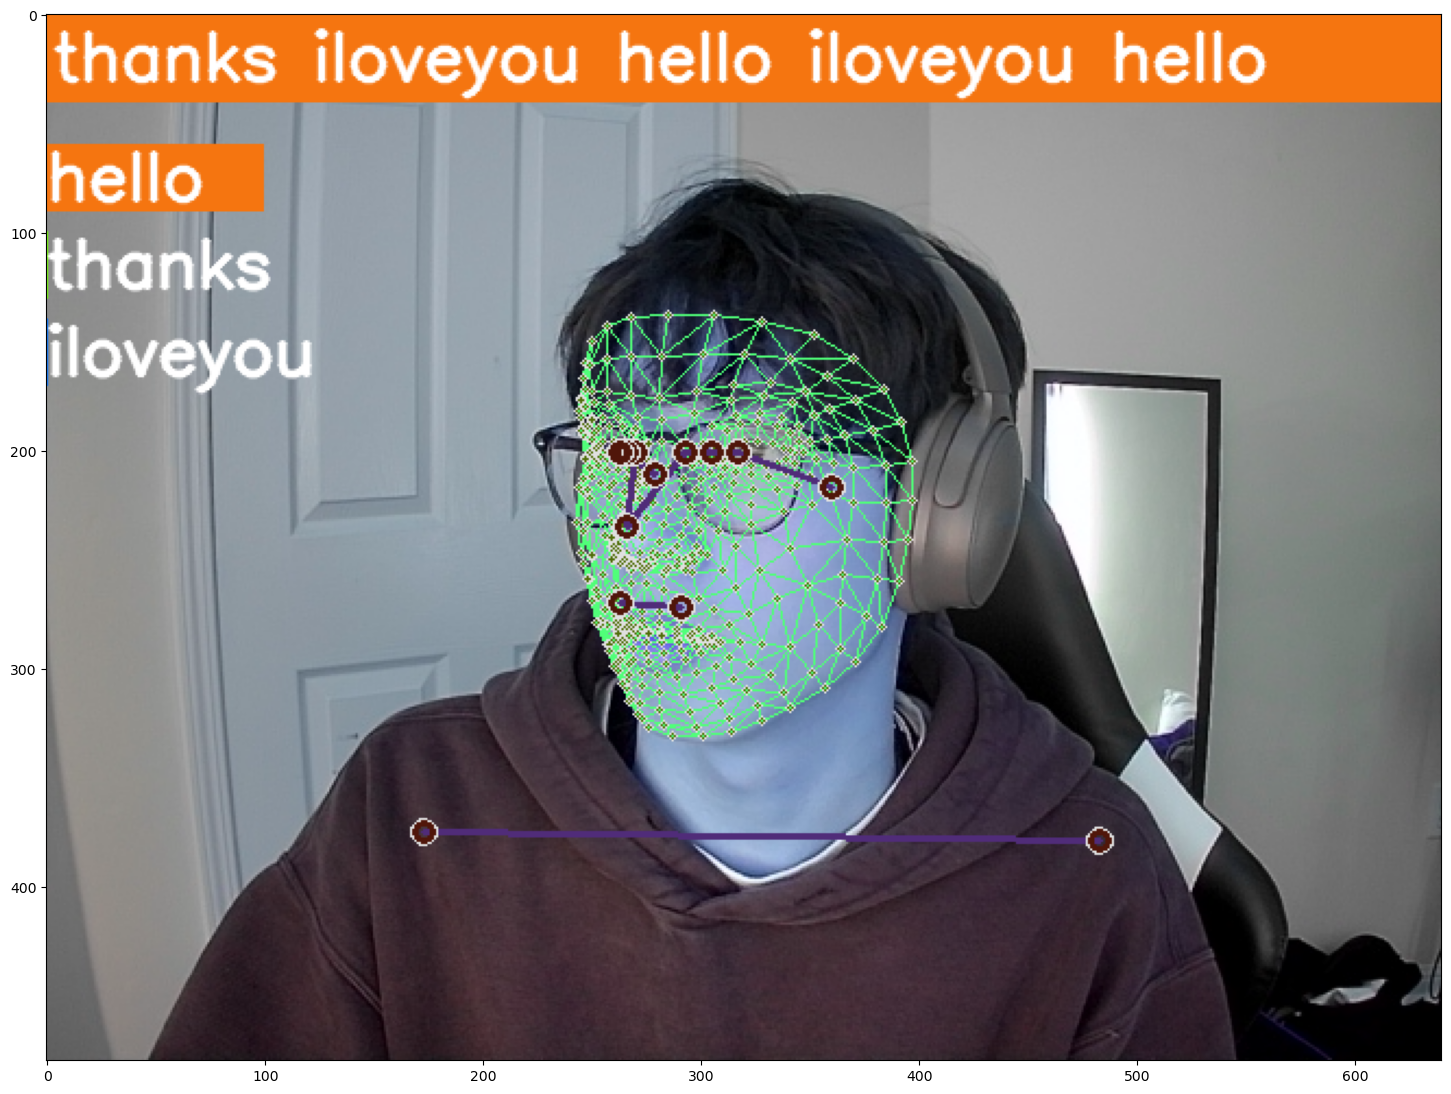

In [60]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [65]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

1/1 [==============================] - 0s 25ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 13ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 17ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
thanks
<cl

1/1 [==============================] - 0s 27ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 14ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 40ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 40ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 15ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 38ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 15ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 10ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 8ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.pytho

1/1 [==============================] - 0s 17ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 7ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.pytho

1/1 [==============================] - 0s 28ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 14ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 43ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 31ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 13ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 58ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 15ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 15ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 13ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 28ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 29ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 15ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 15ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 15ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 17ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 19ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
thanks
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
iloveyou
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
iloveyou
<cl

1/1 [==============================] - 0s 31ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 13ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 8ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 37ms/step
hello
<class 'mediapipe.pytho

1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 15ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 15ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 15ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 19ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 17ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 30ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 13ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 66ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 30ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 11ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 46ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 35ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 14ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 10ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 31ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 15ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 24ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 17ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 17ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 32ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 41ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 38ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 42ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 17ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 17ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 33ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 30ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 18ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 17ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 13ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 17ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 10ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 15ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 17ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 8ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.pytho

1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 34ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 35ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 29ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 27ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 15ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 24ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 15ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 53ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 34ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 72ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 43ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 28ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 27ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 19ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 12ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 10ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 16ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 10ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 26ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.pyth

1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 25ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 22ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 20ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 23ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 21ms/step
hello
<class 'mediapipe.pyth

KeyboardInterrupt: 

In [ ]:
cap.release()
cv2.destroyAllWindows()

In [ ]:
res[np.argmax(res)] > threshold

In [ ]:
(num_sequences,30,1662)

In [ ]:
model.predict(np.expand_dims(X_test[0], axis=0))